# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
# Librerias

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [2]:
# Cargar los datos
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# Ordenar por fecha y hora
data.sort_index(inplace=True)

# Remuestreo por intervalos de 1 hora, sumando los pedidos de cada hora
data = data.resample('1H').sum()

# Mostrar las primeras filas
print(data.head())
print(data.info())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


## Análisis

In [3]:
# Valores nulos
print('Valores nulos:', data.isna().sum())
print()

# Duplicados
print("Fechas duplicadas:", data.index.duplicated().sum())
print()

# Estadistica basica
print('Estadistica descriptiva',data.describe())

Valores nulos: num_orders    0
dtype: int64

Fechas duplicadas: 0

Estadistica descriptiva         num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


### Calidad de los datos

No existe valores nulos

No tenemos valores duplicados en nuestro dataset

En la estadistica descriptiva tenemos un aproximado de 84 pedidos por hora y un maximo de 462 pedidos en una hora, indica una alta variabilidad

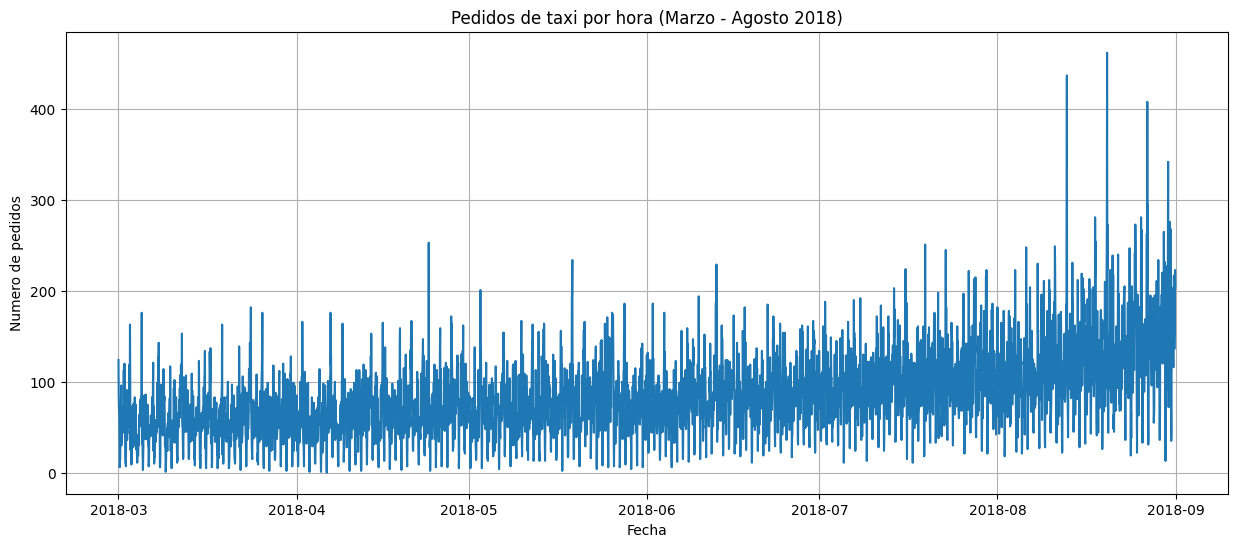

In [4]:
# Visualizacion general de la serie temporal

plt.figure(figsize=(15,6))
plt.plot(data.index, data['num_orders'])
plt.title("Pedidos de taxi por hora (Marzo - Agosto 2018)")
plt.xlabel("Fecha")
plt.ylabel("Numero de pedidos")
plt.grid(True)
plt.show()

El grafico muestra un crecimiento progesivo en la demanda de taxis conforme avanza el tiempo, especialmente para los ultimos meses. se presentan picos extremos de mas de 400 pedidos por hora en ciertos dias de agosto, esto puede darse por eventos especiales, condiciones climaticas o alguna anomalia.

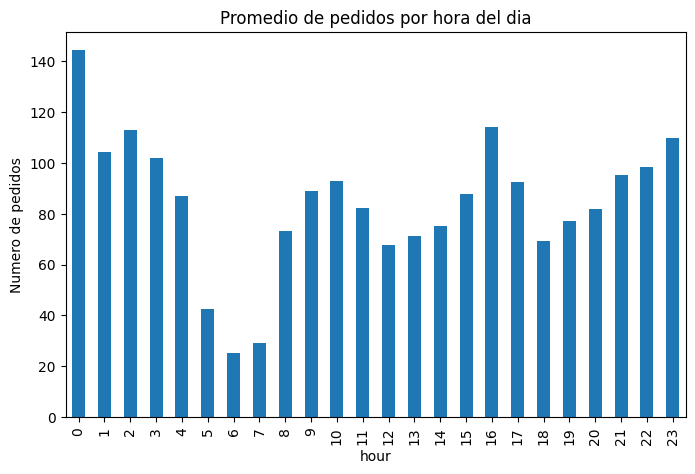

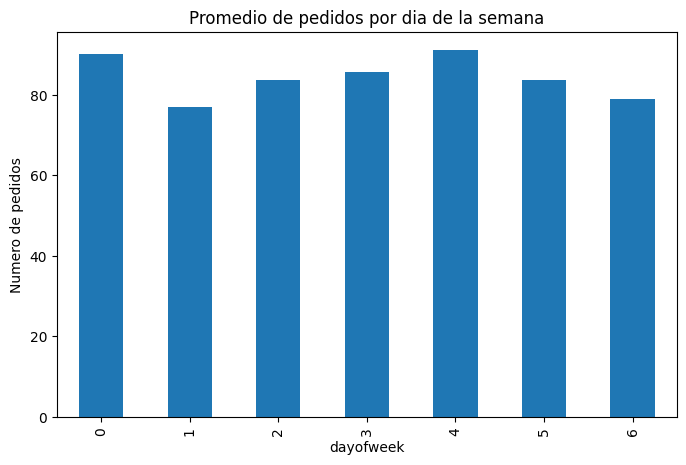

In [5]:
# Hora del dia
data['hour'] = data.index.hour
hourly_mean = data.groupby('hour')['num_orders'].mean()

hourly_mean.plot(kind='bar', figsize=(8,5), title="Promedio de pedidos por hora del dia")
plt.ylabel("Numero de pedidos")
plt.show()

# Dia de la semana (0=lunes, 6=domingo)
data['dayofweek'] = data.index.dayofweek
dow_mean = data.groupby('dayofweek')['num_orders'].mean()

dow_mean.plot(kind='bar', figsize=(8,5), title="Promedio de pedidos por dia de la semana")
plt.ylabel("Numero de pedidos")
plt.show()


### Patrones diarios

Se observan dos picos maximos al rededos de medianoche y nuevamente en la tarde alrededor de las 4pm y unos minimos entre 5am y 7am donde no hay mucha actividad

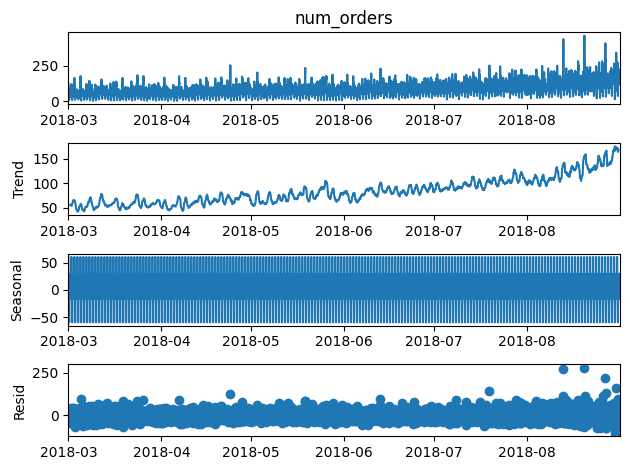

In [6]:
decomposed = seasonal_decompose(data['num_orders'], model='additive', period=24)
decomposed.plot()
plt.show()

### Descomposicion estacional

Tendencia, aumenta sostenido con el tiempo.

Estacionalidad, picos repetitivos diarios (ciclos de 24 horas muy marcados).

Residuos, dispersion que puede deberse a eventos especiales, climas u otros

## Formación

Se crea la funcion `make_features` que generara

Variables de calendario (`year`, `month`, `day`, `dayofweek`, `hour`)

Lags (`lag_1`, `lag_2`, …)

Rolling mean (`rolling_mean`)

In [7]:
# Funcion make_features

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

In [8]:
# Crear features
make_features(data, max_lag=24, rolling_mean_size=24)

# Eliminar filas con NaN creadas por lags/rolling
data = data.dropna()

# Dividir en train/test (90% - 10%)
train_size = int(len(data) * 0.9)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Variables predictoras y target
features = ['year','month','day','dayofweek','hour'] + \
           [f'lag_{i}' for i in range(1,25)] + ['rolling_mean']

X_train, y_train = train[features], train['num_orders']
X_test, y_test = test[features], test['num_orders']


### Modelo de regresion lineal

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)


rmse_train_lr = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, pred_test))


print("Linear Regression RMSE train:", rmse_train_lr)
print("Linear Regression RMSE test:", rmse_test_lr)

Linear Regression RMSE train: 25.704612795967595
Linear Regression RMSE test: 45.83447405433358


### Modelo Random Forest

In [10]:
best_rmse_rf = float("inf")
best_params_rf = None

# Rango de valores a probar
n_estimators_list = [50, 100]
max_depth_list = [5, 10, None]

for n in n_estimators_list:
    for d in max_depth_list:
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=d,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)

        pred_train = rf.predict(X_train)
        pred_test = rf.predict(X_test)

        rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

        if rmse_test < best_rmse_rf:
            best_rmse_rf = rmse_test
            best_params_rf = (n, d, rmse_train, rmse_test)

print("Mejores parametros RandomForest:")
print(f"n_estimators={best_params_rf[0]}, max_depth={best_params_rf[1]}, RMSE train={best_params_rf[2]:.2f}, RMSE test={best_params_rf[3]:.2f}")

Mejores parametros RandomForest:
n_estimators=100, max_depth=None, RMSE train=8.56, RMSE test=42.86


### Modelo LGBM

In [11]:
best_rmse_lgb = float("inf")
best_params_lgb = None

# Rango de valores a probar
n_estimators_list = [100, 300, 500]
max_depth_list = [5, 7, -1]   # -1 significa sin límite en LightGBM
learning_rates = [0.05, 0.1, 0.2]

for n in n_estimators_list:
    for d in max_depth_list:
        for lr in learning_rates:
            lgb_model = lgb.LGBMRegressor(
                n_estimators=n,
                learning_rate=lr,
                max_depth=d,
                random_state=42,
                n_jobs=-1
            )
            lgb_model.fit(X_train, y_train)

            pred_train = lgb_model.predict(X_train)
            pred_test = lgb_model.predict(X_test)

            rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
            rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
            
            if rmse_test < best_rmse_lgb:
                best_rmse_lgb = rmse_test
                best_params_lgb = (n, d, lr, rmse_train, rmse_test)

print("Mejores parametros LightGBM:")
print(f"n_estimators={best_params_lgb[0]}, max_depth={best_params_lgb[1]}, learning_rate={best_params_lgb[2]}, RMSE train={best_params_lgb[3]:.2f}, RMSE test={best_params_lgb[4]:.2f}")

Mejores parametros LightGBM:
n_estimators=300, max_depth=7, learning_rate=0.1, RMSE train=7.05, RMSE test=39.63


In [12]:
# Resumen de los modelos ejecutados
rows = [
    ('LinearRegression', rmse_train_lr, rmse_test_lr),
    ('RandomForest', best_params_rf[2], best_params_rf[3]),   # rmse train y test del mejor RF
    ('LightGBM', best_params_lgb[3], best_params_lgb[4])     # rmse train y test del mejor LGBM
]

summary = pd.DataFrame(rows, columns=['Model', 'RMSE train', 'RMSE test'])
print(summary)

              Model  RMSE train  RMSE test
0  LinearRegression   25.704613  45.834474
1      RandomForest    8.557028  42.862832
2          LightGBM    7.051988  39.633714


**LightGBM** fue el mejor modelo en el conjunto de prueba con un `RMSE` de 39.6, cumpliendo el requisito del proyecto (`RECM` ≤ 48).

**Random Forest** tambien cumplio el criterio, pero con un `RMSE` mayor que LightGBM.

**Linear Regression** estuvo cerca del limite con un `RMSE` de 45.83, lo que demuestra que el problema no es completamente lineal y que los modelos basados en arboles capturan mejor la complejidad de los datos.

La diferencia entre `RMSE` train y `RMSE` test muestra que:

**Linear Regression** generaliza razonablemente (diferencia moderada).

**Random Forest** y **LightGBM** tienen un `RMSE` de train muy bajo, lo que indica que ajustan fuertemente al entrenamiento, pero aun asi generalizan bien porque el `RMSE` en test sigue bajo.

## Prueba

In [13]:
# Definir el modelo con los mejores hiperparametros encontrados
best_lgb = lgb.LGBMRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Entrenar con el conjunto de entrenamiento
best_lgb.fit(X_train, y_train)

# Predicciones
y_pred_train = best_lgb.predict(X_train)
y_pred_test = best_lgb.predict(X_test)

# Evaluación RMSE
rmse_train_final = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test_final = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"RMSE train (LightGBM): {rmse_train_final:.2f}")
print(f"RMSE test (LightGBM): {rmse_test_final:.2f}")

RMSE train (LightGBM): 7.05
RMSE test (LightGBM): 39.63


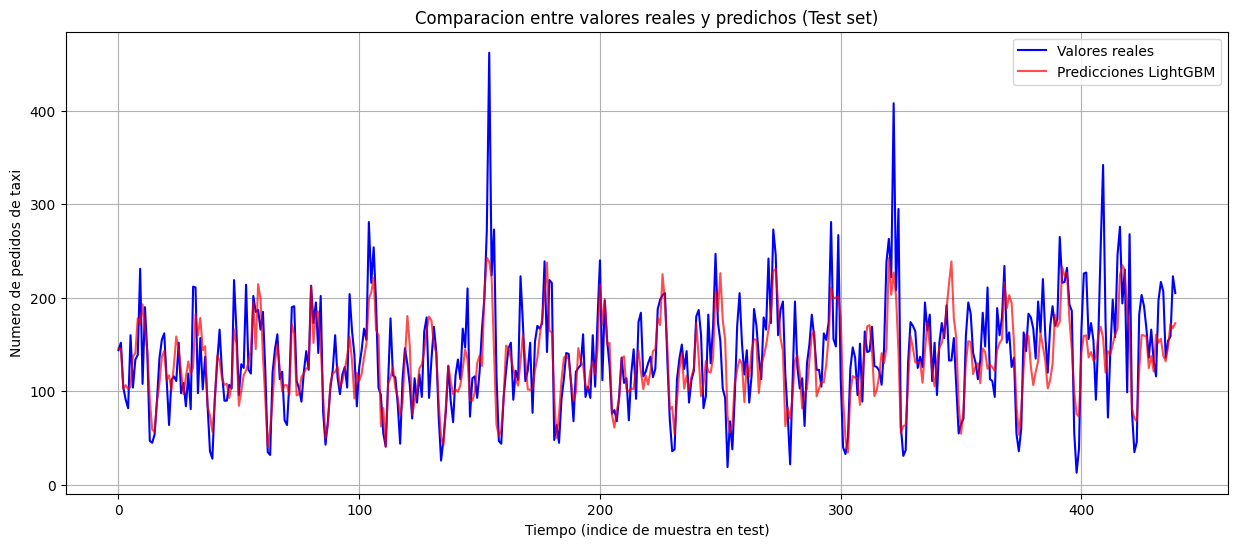

In [14]:
# Graficar valores reales vs predichos en el conjunto de prueba
plt.figure(figsize=(15,6))

plt.plot(y_test.values, label='Valores reales', color='blue')
plt.plot(y_pred_test, label='Predicciones LightGBM', color='red', alpha=0.7)

plt.title("Comparacion entre valores reales y predichos (Test set)")
plt.xlabel("Tiempo (indice de muestra en test)")
plt.ylabel("Numero de pedidos de taxi")
plt.legend()
plt.grid(True)
plt.show()


### Comparacion entre valores reales y predichos

En el grafico se observa que la linea roja (predicciones) sigue bastante bien la tendencia de la linea azul (valores reales).

El modelo capta las tendencias generales y los patrones estacionales horarios y diarios.

Sin embargo, en los picos muy altos de demanda (ej. horas punta con mas de 300–400 pedidos) el modelo tiende a subestimar, lo cual es habitual en modelos de series temporales, ya que los extremos son mas dificiles de anticipar.

### Implicaciones para el negocio

Este modelo puede ser usado para planificar la asignacion de taxis por hora, anticipando la demanda y asegurando que haya mas conductores disponibles en momentos de alta necesidad.

Aunque aun puede fallar en picos extremos, la prediccion promedio es suficientemente precisa para mejorar la operacion diaria.

El mejor modelo para predecir el numero de pedidos de taxis en la siguiente hora es **LightGBM**, ya que ofrece el menor error de prueba 39.6, cumpliendo con el objetivo del proyecto de mantener el `RMSE` por debajo de 48.

Este modelo logra un buen equilibrio entre precision y capacidad de generalizacion, y serIa la opcion recomendada para implementar en produccion.